In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
result_dir = "render_outputs/ecb91f433f144a7798724890f0528b23/"

In [3]:
alphas = np.load(f"{result_dir}/clip_features_alphas.npy")
grid_feature_path = f"{result_dir}/clip_features.npz"
feature_result = np.load(grid_feature_path)

In [4]:

print("scene bounds", feature_result['min_bounds'], feature_result['max_bounds'])

scene bounds [-0.5 -0.5 -0.5] [0.5 0.5 0.5]


In [5]:
print("density:", np.max(alphas), np.min(alphas), np.mean(alphas))

density: 1.0 0.0 0.3418


In [6]:
## The point cloud is a sparse representation of the voxel grid. 
# Created by just getting the non-empty voxels via `alpha_threshold` (density threshold). 
# Then remove the gray background via `gray_threshold`.
ply_path = f"{result_dir}/clip_features_pc.ply"

In [7]:
import trimesh
pc = trimesh.load(ply_path)
points = np.asarray(pc.vertices)
colors = np.asarray(pc.colors)

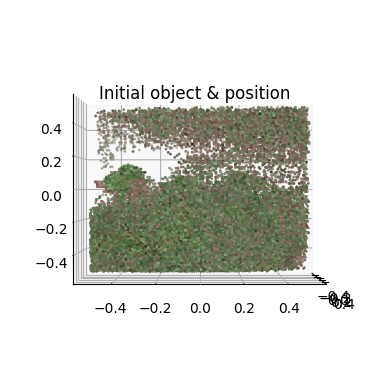

In [8]:
# Visualize initial object & position
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if colors.max() > 1.0:
    colors = colors / 255.0

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1,
           c=colors)
ax.set_title(f"Initial object & position", y = 0.8)

ax.view_init(elev=0, azim=0)
plt.show()

In [9]:
query = "pot"
device="cuda"

In [10]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import open3d as o3d
from typing import Tuple, Dict, Any
from f3rm.features.clip import clip, tokenize
from f3rm.features.clip.model import CLIP
from f3rm.features.clip_extract import CLIPArgs


def get_heatmap(values, invert=False, cmap_name="plasma", normalize_range=(0.0, 1.0), only_show_match=True, threshold=0.5):
    """
    Get a heatmap for the given values using the specified colormap.
    
    Args:
        values: Tensor of values to visualize
        invert: Whether to invert the colormap
        cmap_name: Name of the colormap to use
        normalize_range: Range to normalize values to before applying colormap
        only_show_match: If True, points with low correlation will be transparent
        threshold: Threshold for determining low correlation (when only_show_match is True)
    """
    cmap = cm.get_cmap(cmap_name)
    if len(values) == 0:
        return np.zeros((0, 4))  # Return RGBA with alpha channel
    
    # Convert to numpy
    values_np = values.cpu().numpy()
    
    # Normalize values to specified range
    min_val, max_val = normalize_range
    if values_np.max() != values_np.min():
        normalized = (values_np - values_np.min()) / (values_np.max() - values_np.min())
        normalized = normalized * (max_val - min_val) + min_val
        # Clip to ensure within range
        normalized = np.clip(normalized, min_val, max_val)
        
        # Rescale to [0, 1] for colormap
        normalized_for_cmap = (normalized - min_val) / (max_val - min_val)
    else:
        normalized = np.zeros_like(values_np)
        normalized_for_cmap = np.zeros_like(values_np)
    
    if invert:
        normalized_for_cmap = 1 - normalized_for_cmap
    
    # Apply colormap to get RGBA values
    colors = cmap(normalized_for_cmap)
    
    # If only_show_match is True, set alpha to 0 for points below threshold
    if only_show_match:
        # Create a mask for points below threshold
        # Normalize threshold to same scale as normalized values
        norm_threshold = (threshold - min_val) / (max_val - min_val) if max_val != min_val else 0
        mask = normalized_for_cmap < norm_threshold
        
        # Set alpha to 0 for points below threshold
        colors[mask, 3] = 0.0
    
    return colors  # Return RGBA with alpha channel

def otsu_mask(values):
    """Apply Otsu thresholding to separate foreground from background."""
    if len(values) == 0:
        return torch.zeros_like(values, dtype=torch.bool), 0.0
    
    # Convert to numpy for histogram calculation
    values_np = values.cpu().numpy()
    
    # Calculate histogram
    hist, bin_edges = np.histogram(values_np, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate cumulative sums
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Calculate means
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    
    # Calculate variance between classes
    variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # Find threshold that maximizes variance
    idx = np.argmax(variance)
    threshold = bin_centers[idx]
    
    # Apply threshold
    mask = values >= threshold
    return mask, threshold


def get_initial_voxel_grid_from_saved(
    grid_feature_path: str,
    query: str,
    clip_model,
    device: str = "cuda",
    alpha_threshold: float = 0.01,
    softmax_temperature: float = 0.1,
    voxel_size: float = 0.01
) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, int]]:
    """
    Get the initial masked voxel grid based on density (alpha) and language (CLIP features).
    This function works with pre-extracted voxel grid data.
    
    Args:
        grid_feature_path: Path to the saved feature grid metadata (.npz file)
        query: Text query to filter voxels
        clip_model: CLIP model for text encoding
        device: Device to use for computation
        alpha_threshold: Threshold for density values
        softmax_temperature: Temperature for softmax when computing language probabilities
        voxel_size: Size of each voxel
        
    Returns:
        Tuple containing:
        - voxel_grid: Tensor of shape (num_voxels, 3) containing filtered voxel coordinates
        - voxel_sims: Tensor of shape (num_voxels) containing similarities with language query
        - metrics: Dictionary with metrics about filtering process
    """
    print(f"Loading feature grid from {grid_feature_path}...")
    
    # Load metadata
    metadata = np.load(grid_feature_path)
    min_bounds = metadata['min_bounds']
    max_bounds = metadata['max_bounds']
    grid_shape = metadata['grid_shape']
    
    print(f"Grid shape: {grid_shape}, voxel size: {voxel_size}")
    print(f"Bounds: min={min_bounds}, max={max_bounds}")
    
    # Load alphas
    alphas_path = grid_feature_path.replace('.npz', '_alphas.npy')
    print(f"Loading alphas from {alphas_path}...")
    alphas = np.load(alphas_path)
    
    # Load features
    features_path = grid_feature_path.replace('.npz', '_features.npy')
    print(f"Loading features from {features_path}...")
    features = np.load(features_path)
    
    # Load RGB
    rgb_path = grid_feature_path.replace('.npz', '_rgb.npy')
    print(f"Loading RGB from {rgb_path}...")
    rgb = np.load(rgb_path)
    
    # Convert to torch tensors
    alphas_tensor = torch.from_numpy(alphas).to(device)
    features_tensor = torch.from_numpy(features).to(device)
    rgb_tensor = torch.from_numpy(rgb).to(device)
    
    # Create coordinate grid
    print("Creating coordinate grid...")
    x = torch.linspace(min_bounds[0], max_bounds[0], grid_shape[0], device=device)
    y = torch.linspace(min_bounds[1], max_bounds[1], grid_shape[1], device=device)
    z = torch.linspace(min_bounds[2], max_bounds[2], grid_shape[2], device=device)
    
    grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing='ij')
    coords = torch.stack([grid_x, grid_y, grid_z], dim=-1)
    
    # Flatten everything for processing
    coords_flat = coords.reshape(-1, 3)
    alphas_flat = alphas_tensor.reshape(-1, 1)
    features_flat = features_tensor.reshape(-1, features_tensor.shape[-1])
    rgb_flat = rgb_tensor.reshape(-1, 3)
    
    # Track metrics
    metrics = {"initial": len(coords_flat)}
    
    # Apply density thresholding
    print(f"Applying density threshold {alpha_threshold}...")
    density_mask = alphas_flat.squeeze(-1) > alpha_threshold
    coords_filtered = coords_flat[density_mask]
    features_filtered = features_flat[density_mask]
    rgb_filtered = rgb_flat[density_mask]
    
    metrics["density_masked"] = len(coords_filtered)
    print(f"After density filtering: {len(coords_filtered)} points")
    
    # Apply gray background filtering
    print("Applying gray background filtering...")
    rgb_std = rgb_filtered.std(dim=-1)
    non_gray_mask = rgb_std > 0.05  # Gray threshold
    
    coords_filtered = coords_filtered[non_gray_mask]
    features_filtered = features_filtered[non_gray_mask]
    
    metrics["gray_filtered"] = len(coords_filtered)
    print(f"After gray filtering: {len(coords_filtered)} points")
    
    # Feature masking by comparing each voxel's feature with the user query and negatives
    print("Applying language filtering...")
    queries = [query, "object", "things", "stuff", "texture"]  # Negatives from LERF
    
    # Encode text queries
    with torch.no_grad():
        text_inputs = clip.tokenize(queries).to(device)
        query_embs = clip_model.encode_text(text_inputs).float()
        query_embs /= query_embs.norm(dim=-1, keepdim=True)
    
    
    # Normalize features
    features_filtered = features_filtered.to(torch.float32)
    features_filtered /= features_filtered.norm(dim=-1, keepdim=True)
    
    # Compute similarities and softmax
    voxel_sims = features_filtered @ query_embs.T
    probs = voxel_sims / softmax_temperature
    probs = torch.nn.functional.softmax(probs, dim=-1)
    probs = torch.nan_to_num_(probs, nan=1e-7)
    
    # Sample from distribution, 0-index is the positive query
    labels = torch.multinomial(probs, num_samples=1)
    softmax_mask = (labels == 0).squeeze()
    
    coords_filtered = coords_filtered[softmax_mask]
    voxel_sims_filtered = voxel_sims[:, 0][softmax_mask]
    
    metrics["language_masked"] = len(coords_filtered)
    print(f"After language filtering: {len(coords_filtered)} points")
    
    return coords_filtered, voxel_sims_filtered, metrics

def visualize_filtered_voxels(voxel_grid, voxel_sims=None, title="Filtered Voxels"):
    """Visualize the filtered voxels with optional heatmap coloring."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    points = voxel_grid.cpu().numpy()
    
    if voxel_sims is not None:
        colors = get_heatmap(voxel_sims, only_show_match=False)
    else:
        colors = np.ones((len(points), 3)) * 0.5  # Gray if no similarities
    
    ## add colorbar
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.plasma), ax=ax)
    cbar.set_label('Similarity')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=5)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.tight_layout()
    return fig

def save_filtered_point_cloud(voxel_grid, voxel_sims, output_path):
    """Save the filtered voxels as a point cloud with heatmap coloring."""
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(voxel_grid.cpu().numpy())
    
    # Color by similarity
    colors = get_heatmap(voxel_sims)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Save to file
    o3d.io.write_point_cloud(output_path, pcd)
    print(f"Saved filtered point cloud to {output_path}")
    return pcd

def main(grid_feature_path, query, output_dir="./filtered_results", device="cuda"):
    """Main function to run the filtering pipeline."""
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Load CLIP model
    clip_model, _ = clip.load(CLIPArgs.model_name, device=device)
    
    # Get filtered voxel grid
    voxel_grid, voxel_sims, metrics = get_initial_voxel_grid_from_saved(
        grid_feature_path,
        query,
        clip_model,
        device=device
    )
    
    # Visualize results
    fig = visualize_filtered_voxels(voxel_grid, voxel_sims, f'Filtered Voxels for "{query}"')
    fig.savefig(output_dir / f"{query}_filtered_voxels.png")
    
    # Save as point cloud
    # save_filtered_point_cloud(voxel_grid, voxel_sims, str(output_dir / f"{query}_filtered.ply"))
    
    # Save metrics
    with open(output_dir / f"{query}_metrics.txt", "w") as f:
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")
    
    return voxel_grid, voxel_sims, metrics

OSError: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /mnt/kostas-graid/sw/envs/vlongle/miniconda3/envs/diffphys3d/lib/python3.8/site-packages/open3d/cpu/pybind.cpython-38-x86_64-linux-gnu.so)

In [11]:
query="leaves" ## work for leaves, pot, ficus (leaves + trunk). Doesn't work for trunk, wood ect.

In [ ]:
main(grid_feature_path, query, output_dir="./filtered_results", device="cuda")